In [23]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import gc
from tqdm.notebook import trange, tqdm
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
import glob
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, Input, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (BatchNormalization, Conv2DTranspose, 
                                     SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense)
from keras.callbacks import CSVLogger
K.clear_session()
warnings.filterwarnings('ignore')
plt.style.use("ggplot")
%matplotlib inline



In [24]:
#Parameters
w, h = 256,256
border = 5     

ids = next(os.walk("SegTMS/train/"))[1] 
print("No. of folder = ", len(ids))

No. of folder =  2


In [25]:
#Load data
train = sorted(glob.glob("SegTMS/train/Images/*"))
train_mask = sorted(glob.glob("SegTMS/train/Labels/*.png"))#[:64]
print(f'Total Train Images : {len(train)}\nTotal Mask Image : {len(train_mask)}')  

Total Train Images : 200
Total Mask Image : 200


In [26]:
#data processing
X=[]
y=[]
X = np.zeros((len(train), h, w, 3), dtype=np.float32)
y = np.zeros((len(train_mask), h, w, 1), dtype=np.float32)
     

for n, (img, mimg) in tqdm(enumerate(zip(train, train_mask))):
    # Load images
    img = load_img(img)
    x_img = img_to_array(img)
    x_img = resize(x_img, (h, w, 3), mode = 'constant', preserve_range = True)
    # # Load masks
    mask = img_to_array(load_img(mimg, color_mode = "grayscale"))
    mask = resize(mask, (h, w, 1), mode = 'constant', preserve_range = True)
    # # Save images
    X[n] = x_img/255.0
    y[n] = mask/255.0

0it [00:00, ?it/s]

In [27]:
# Save as in Numpy array
np.save('SegTMS/XandY/X.npy', X)
np.save('SegTMS/XandY/y.npy', y)

#load data
X = np.load('SegTMS/XandY/X.npy')
y = np.load('SegTMS/XandY/y.npy')

# Split train and valid
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
gc.collect()
print(X.shape, y.shape)
print(X.shape, y.shape)

(180, 256, 256, 3) (180, 256, 256, 1) (20, 256, 256, 3) (20, 256, 256, 1)
(200, 256, 256, 3) (200, 256, 256, 1)
(200, 256, 256, 3) (200, 256, 256, 1)


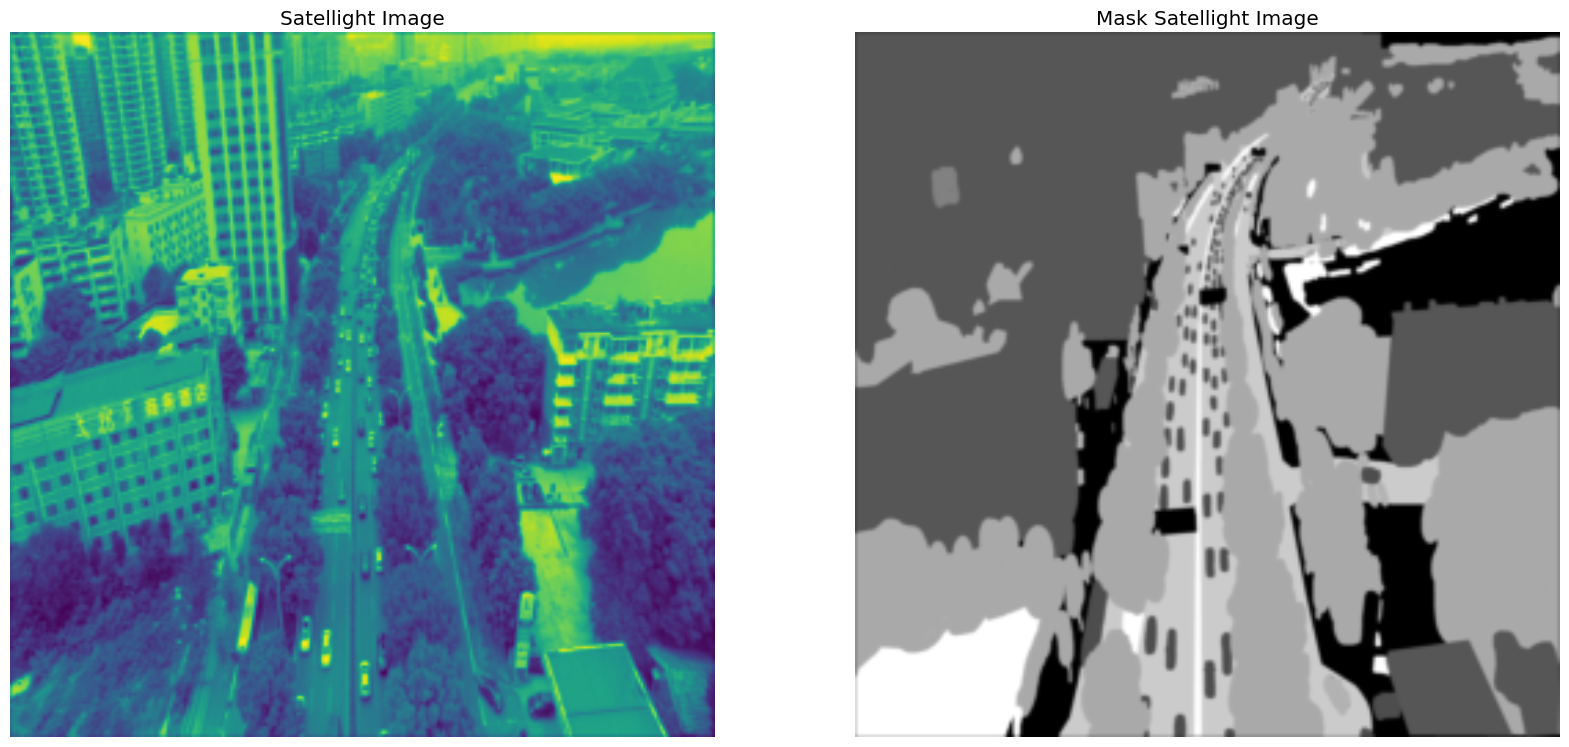

In [28]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], interpolation = 'bilinear')

if has_mask: 
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Satellight Image')
ax1.set_axis_off()
ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Mask Satellight Image')
ax2.set_axis_off()

In [29]:
#valid tensor gen
nbatch=8
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(nbatch)
valset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(nbatch)

2023-03-04 23:54:29.062138: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-03-04 23:54:29.062267: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (picox): /proc/driver/nvidia/version does not exist
2023-03-04 23:54:29.187110: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
